In [1]:
import os
import warnings
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# ---- Config / paths ----
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
ROOT = None
try:
    ROOT = Path(__file__).resolve().parent
except NameError:
    import os
    ROOT = Path(os.getcwd())

TRAIN_CSV = ROOT / "train-final.csv"
TEST_CSV  = ROOT / "test-final.csv"
PROCESSED = ROOT / "processed.csv"
ARTIFACT_DIR = ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

In [3]:
# ---- Utilities ----
def detect_feature_columns(df: pd.DataFrame) -> List[str]:
    # Preferred patterns
    for prefix in ("pos_mean_", "pos_std_", "ang_mean_", "ang_std_"):
        cols = [c for c in df.columns if c.startswith(prefix)]
        if cols:
            # return full set of pos_/ang_ features if present
            all_cols = sorted([c for c in df.columns if c.startswith(("pos_mean_", "pos_std_", "ang_mean_", "ang_std_"))])
            if all_cols:
                return all_cols
    # fallback to f1..fN
    fcols = [c for c in df.columns if c.startswith("f") and c[1:].isdigit()]
    if fcols:
        fcols_sorted = sorted(fcols, key=lambda x: int(x[1:]))
        return fcols_sorted
    # fallback: numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return numeric_cols

def load_data() -> Tuple[pd.DataFrame, pd.DataFrame, List[str], str]:
    """
    Return train_df, test_df, feature_columns, label_col
    """
    if TRAIN_CSV.exists() and TEST_CSV.exists():
        print("Loading existing train-final.csv and test-final.csv")
        train_df = pd.read_csv(TRAIN_CSV)
        test_df  = pd.read_csv(TEST_CSV)
    elif PROCESSED.exists():
        print("train/test not found. Loading processed.csv and creating stratified split...")
        full = pd.read_csv(PROCESSED)
        # find label
        if "label_name" in full.columns and full["label_name"].notna().sum() > 0:
            label_col = "label_name"
        elif "label_id" in full.columns and full["label_id"].notna().sum() > 0:
            label_col = "label_id"
        else:
            raise RuntimeError("No labels found in processed.csv or train/test CSVs.")
        # keep only labeled rows
        mask = full[label_col].notna()
        df_labeled = full.loc[mask].reset_index(drop=True)
        feat_cols = detect_feature_columns(df_labeled)
        if len(feat_cols) == 0:
            raise RuntimeError("No feature columns detected in processed.csv")
        X = df_labeled[feat_cols]
        y = df_labeled[label_col].astype(str)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        train_df = pd.concat([X_train.reset_index(drop=True), df_labeled.loc[X_train.index, df_labeled.columns.difference(feat_cols)].reset_index(drop=True)], axis=1)
        test_df  = pd.concat([X_test.reset_index(drop=True),  df_labeled.loc[X_test.index,  df_labeled.columns.difference(feat_cols)].reset_index(drop=True)], axis=1)
    else:
        raise FileNotFoundError("No train-final/test-final or processed.csv found in working directory.")

    feature_cols = detect_feature_columns(train_df)
    # determine label col
    if "label_name" in train_df.columns and train_df["label_name"].notna().any():
        label_col = "label_name"
    elif "label_id" in train_df.columns and train_df["label_id"].notna().any():
        label_col = "label_id"
    else:
        raise RuntimeError("No usable label column in train/test data.")

    return train_df, test_df, feature_cols, label_col

In [4]:
def prepare_xy(train_df: pd.DataFrame, test_df: pd.DataFrame, feature_cols: List[str], label_col: str):
    # drop rows with missing labels
    before_train = len(train_df)
    before_test  = len(test_df)
    train_df = train_df.loc[train_df[label_col].notna()].reset_index(drop=True)
    test_df  = test_df.loc[test_df[label_col].notna()].reset_index(drop=True)
    print(f"Dropped {before_train - len(train_df)} rows from train and {before_test - len(test_df)} from test due to missing labels.")

    X_train = train_df[feature_cols].values
    X_test  = test_df[feature_cols].values

    # Impute if necessary (should be already imputed in preprocessing but safe)
    imputer = SimpleImputer(strategy="median")
    X_train = imputer.fit_transform(X_train)
    X_test  = imputer.transform(X_test)
    joblib.dump(imputer, ARTIFACT_DIR / "imputer.joblib")

    # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    joblib.dump(scaler, ARTIFACT_DIR / "scaler.joblib")

    # labels -> encoded ints
    y_train_raw = train_df[label_col].astype(str).values
    y_test_raw  = test_df[label_col].astype(str).values
    le = LabelEncoder()
    y_train = le.fit_transform(y_train_raw)
    y_test  = le.transform(y_test_raw)  # if test contains unseen labels it'll error -> expect labels in train
    joblib.dump(le, ARTIFACT_DIR / "label_encoder.joblib")
    class_names = le.classes_.tolist()
    print(f"Detected {len(class_names)} classes: {class_names}")

    return X_train, X_test, y_train, y_test, class_names

In [5]:
def fit_and_eval(model, X_train, y_train, X_test, y_test, class_names, name="model", save=True):
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    if save:
        joblib.dump(model, ARTIFACT_DIR / f"{name}.joblib")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    print(f"{name} -> Accuracy: {acc:.4f}, Macro-F1: {f1m:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return {"name": name, "model": model, "accuracy": acc, "f1_macro": f1m, "y_pred": y_pred}

In [6]:
def evaluate_with_pca(base_model_class, base_model_params, X_train, y_train, X_test, y_test, class_names, variance_target, model_name_prefix):
    """
    Fit PCA on X_train to keep variance_target (0-1), transform train/test,
    train the same model type on reduced data, evaluate.
    base_model_class: sklearn estimator class (not instance)
    base_model_params: dict for init
    """
    print(f"\nApplying PCA to keep {int(variance_target*100)}% variance (fit on train)...")
    pca = PCA(n_components=variance_target, svd_solver="full", random_state=RANDOM_STATE)
    X_train_p = pca.fit_transform(X_train)
    X_test_p  = pca.transform(X_test)
    print("Original dim:", X_train.shape[1], "Reduced dim:", X_train_p.shape[1])
    joblib.dump(pca, ARTIFACT_DIR / f"pca_{int(variance_target*100)}.joblib")

    model = base_model_class(**base_model_params)
    model.fit(X_train_p, y_train)
    joblib.dump(model, ARTIFACT_DIR / f"{model_name_prefix}_pca_{int(variance_target*100)}.joblib")
    y_pred = model.predict(X_test_p)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    print(f"{model_name_prefix} + PCA {int(variance_target*100)}% -> Acc: {acc:.4f}, MacroF1: {f1m:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name_prefix} + PCA {int(variance_target*100)}%")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return {"variance": variance_target, "accuracy": acc, "f1_macro": f1m, "reduced_dim": X_train_p.shape[1]}

Loading existing train-final.csv and test-final.csv
Using label column: label_name
Number of feature columns: 240
Dropped 0 rows from train and 0 from test due to missing labels.
Detected 30 classes: ['afternoon', 'baby', 'big', 'born', 'bye', 'calendar', 'child', 'cloud', 'come', 'daily', 'dance', 'dark', 'day', 'enjoy', 'go', 'hello', 'home', 'love', 'my', 'name', 'no', 'rain', 'sorry', 'strong', 'study', 'thankyou', 'welcome', 'wind', 'yes', 'you']

Training DecisionTree ...
DecisionTree -> Accuracy: 0.7352, Macro-F1: 0.7344
Classification Report:
              precision    recall  f1-score   support

   afternoon       0.95      1.00      0.97        18
        baby       0.95      1.00      0.97        18
         big       0.55      0.61      0.58        18
        born       0.94      0.83      0.88        18
         bye       0.71      0.56      0.62        18
    calendar       0.88      0.83      0.86        18
       child       0.56      0.56      0.56        18
       clo

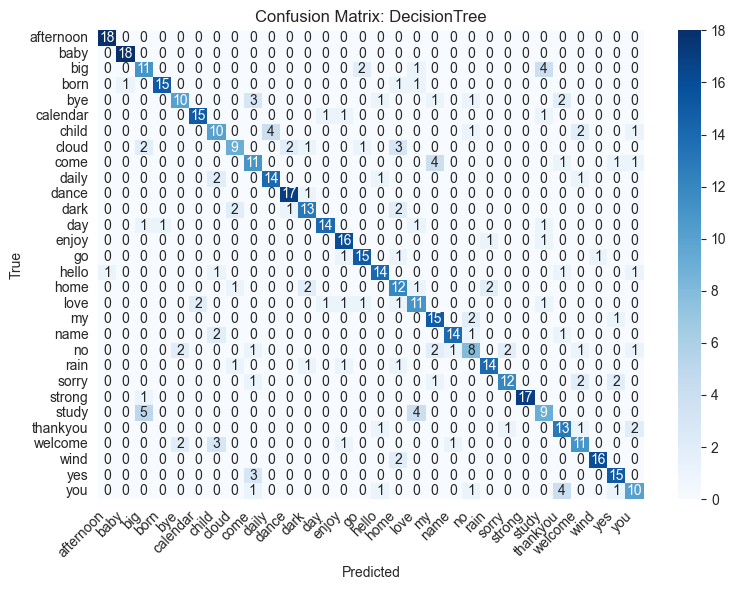


Training RandomForest ...
RandomForest -> Accuracy: 0.9222, Macro-F1: 0.9221
Classification Report:
              precision    recall  f1-score   support

   afternoon       1.00      1.00      1.00        18
        baby       1.00      1.00      1.00        18
         big       0.95      1.00      0.97        18
        born       1.00      1.00      1.00        18
         bye       1.00      0.78      0.88        18
    calendar       1.00      0.94      0.97        18
       child       0.82      0.78      0.80        18
       cloud       0.88      0.83      0.86        18
        come       0.74      0.78      0.76        18
       daily       0.75      1.00      0.86        18
       dance       1.00      1.00      1.00        18
        dark       0.94      0.89      0.91        18
         day       0.95      1.00      0.97        18
       enjoy       0.90      1.00      0.95        18
          go       0.95      1.00      0.97        18
       hello       0.81      0.94 

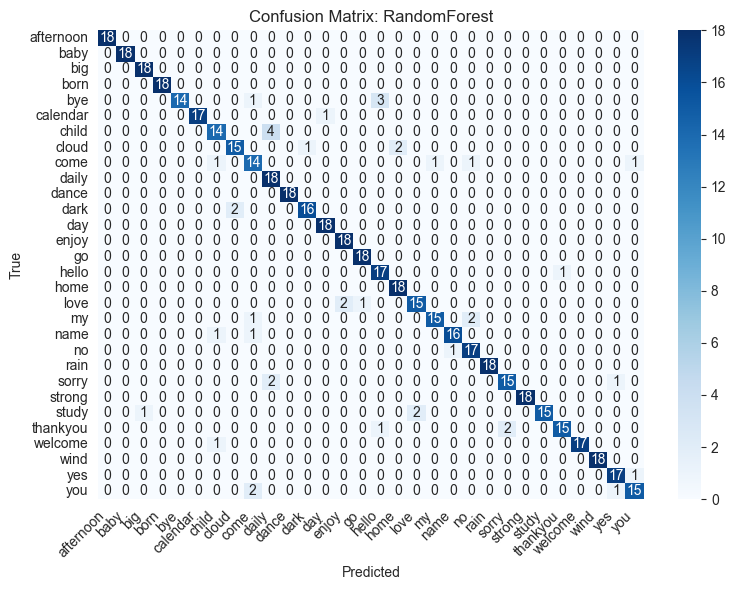


Training kNN ...
kNN -> Accuracy: 0.4204, Macro-F1: 0.4166
Classification Report:
              precision    recall  f1-score   support

   afternoon       0.58      0.61      0.59        18
        baby       0.59      0.89      0.71        18
         big       0.57      0.72      0.63        18
        born       0.44      0.61      0.51        18
         bye       0.14      0.28      0.19        18
    calendar       0.56      0.56      0.56        18
       child       0.30      0.44      0.36        18
       cloud       0.65      0.61      0.63        18
        come       0.31      0.22      0.26        18
       daily       0.36      0.44      0.40        18
       dance       0.81      0.72      0.76        18
        dark       0.83      0.56      0.67        18
         day       0.61      0.78      0.68        18
       enjoy       0.38      0.44      0.41        18
          go       0.33      0.11      0.17        18
       hello       0.31      0.22      0.26        1

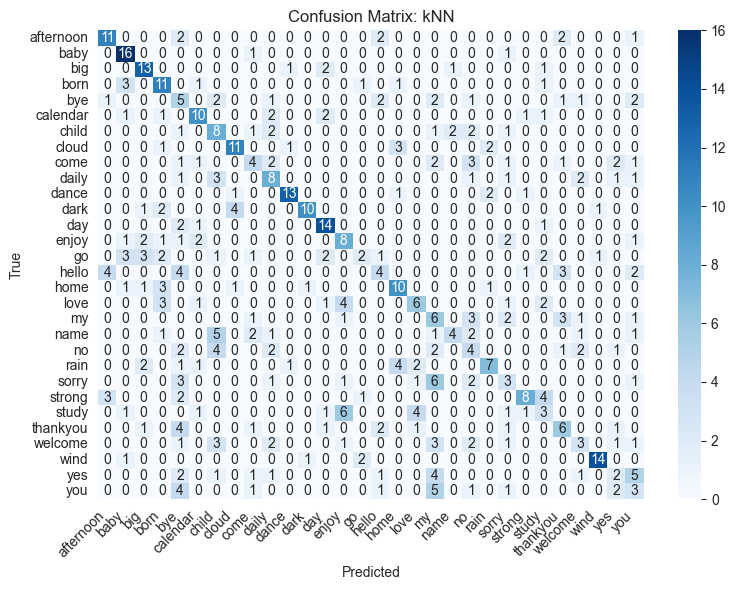


Training MLP ...
MLP -> Accuracy: 0.8741, Macro-F1: 0.8737
Classification Report:
              precision    recall  f1-score   support

   afternoon       0.95      1.00      0.97        18
        baby       0.94      0.89      0.91        18
         big       0.94      0.89      0.91        18
        born       0.94      0.94      0.94        18
         bye       0.84      0.89      0.86        18
    calendar       0.85      0.94      0.89        18
       child       0.81      0.72      0.76        18
       cloud       0.89      0.94      0.92        18
        come       0.75      0.83      0.79        18
       daily       0.80      0.89      0.84        18
       dance       1.00      0.89      0.94        18
        dark       0.81      0.72      0.76        18
         day       0.89      0.94      0.92        18
       enjoy       1.00      0.94      0.97        18
          go       0.82      0.78      0.80        18
       hello       0.88      0.78      0.82        1

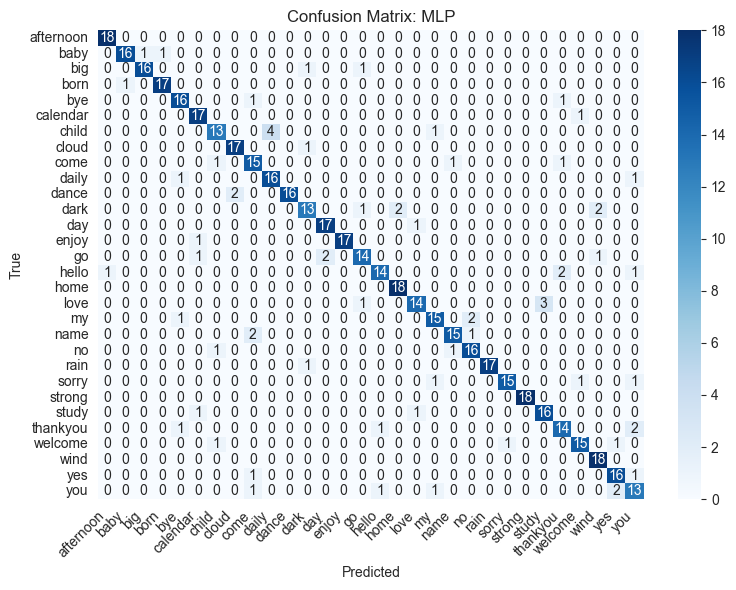


Training SVM ...
SVM -> Accuracy: 0.6944, Macro-F1: 0.6986
Classification Report:
              precision    recall  f1-score   support

   afternoon       0.85      0.94      0.89        18
        baby       0.85      0.94      0.89        18
         big       0.94      0.89      0.91        18
        born       0.88      0.83      0.86        18
         bye       0.54      0.39      0.45        18
    calendar       0.84      0.89      0.86        18
       child       0.56      0.56      0.56        18
       cloud       0.79      0.83      0.81        18
        come       0.35      0.61      0.45        18
       daily       0.71      0.83      0.77        18
       dance       1.00      0.89      0.94        18
        dark       0.58      0.83      0.68        18
         day       0.85      0.94      0.89        18
       enjoy       0.76      0.72      0.74        18
          go       0.92      0.61      0.73        18
       hello       0.59      0.56      0.57        1

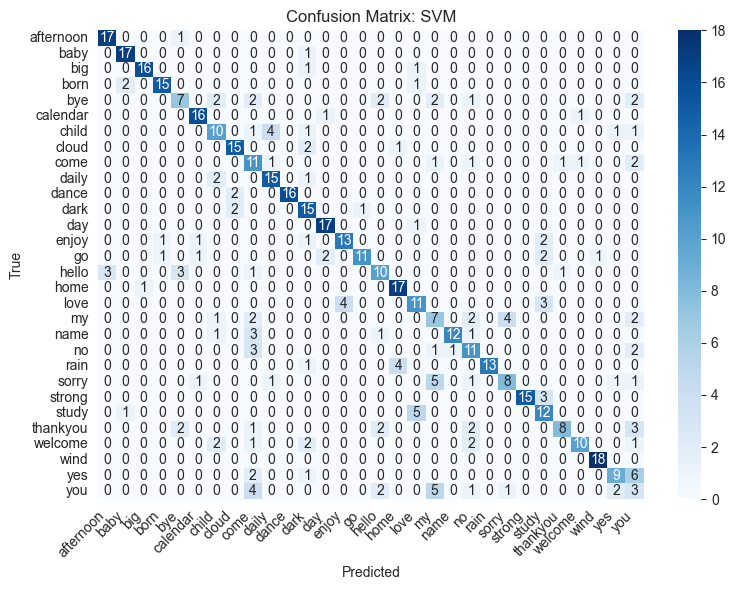


===== Model Summary (sorted) =====
           name  accuracy  f1_macro
0  RandomForest  0.922222  0.922060
1           MLP  0.874074  0.873700
2  DecisionTree  0.735185  0.734440
3           SVM  0.694444  0.698568
4           kNN  0.420370  0.416556

Top 2 models chosen for PCA experiments: ['RandomForest', 'MLP']

Applying PCA to keep 90% variance (fit on train)...
Original dim: 240 Reduced dim: 40
RandomForest + PCA 90% -> Acc: 0.7185, MacroF1: 0.7159
              precision    recall  f1-score   support

   afternoon       0.86      1.00      0.92        18
        baby       0.65      0.72      0.68        18
         big       0.74      0.78      0.76        18
        born       0.81      0.72      0.76        18
         bye       0.52      0.61      0.56        18
    calendar       0.88      0.78      0.82        18
       child       0.58      0.61      0.59        18
       cloud       0.68      0.72      0.70        18
        come       0.63      0.67      0.65        18

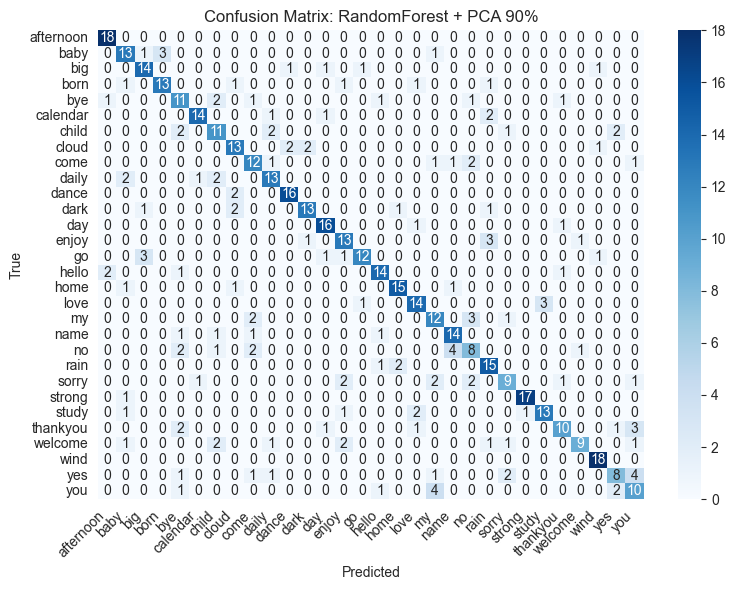


Applying PCA to keep 80% variance (fit on train)...
Original dim: 240 Reduced dim: 21
RandomForest + PCA 80% -> Acc: 0.6815, MacroF1: 0.6798
              precision    recall  f1-score   support

   afternoon       0.84      0.89      0.86        18
        baby       0.75      0.83      0.79        18
         big       0.70      0.78      0.74        18
        born       0.92      0.61      0.73        18
         bye       0.61      0.61      0.61        18
    calendar       0.55      0.67      0.60        18
       child       0.50      0.61      0.55        18
       cloud       0.65      0.72      0.68        18
        come       0.60      0.67      0.63        18
       daily       0.57      0.67      0.62        18
       dance       0.88      0.78      0.82        18
        dark       0.93      0.72      0.81        18
         day       0.71      0.83      0.77        18
       enjoy       0.55      0.67      0.60        18
          go       0.80      0.67      0.73    

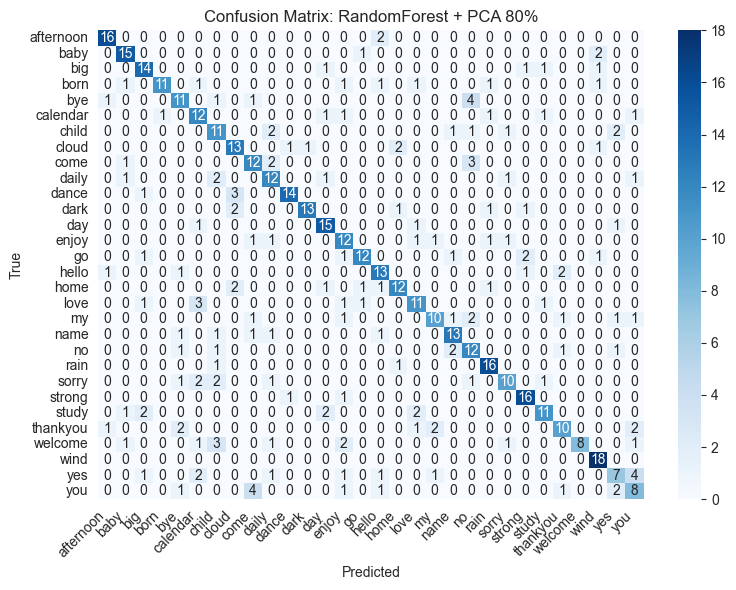


Applying PCA to keep 90% variance (fit on train)...
Original dim: 240 Reduced dim: 40
MLP + PCA 90% -> Acc: 0.8407, MacroF1: 0.8395
              precision    recall  f1-score   support

   afternoon       0.95      1.00      0.97        18
        baby       1.00      0.94      0.97        18
         big       1.00      0.83      0.91        18
        born       0.85      0.94      0.89        18
         bye       0.91      0.56      0.69        18
    calendar       0.94      0.89      0.91        18
       child       0.75      0.67      0.71        18
       cloud       0.82      1.00      0.90        18
        come       0.70      0.78      0.74        18
       daily       0.75      0.83      0.79        18
       dance       1.00      0.94      0.97        18
        dark       1.00      0.83      0.91        18
         day       0.90      1.00      0.95        18
       enjoy       0.94      0.94      0.94        18
          go       0.94      0.89      0.91        18
  

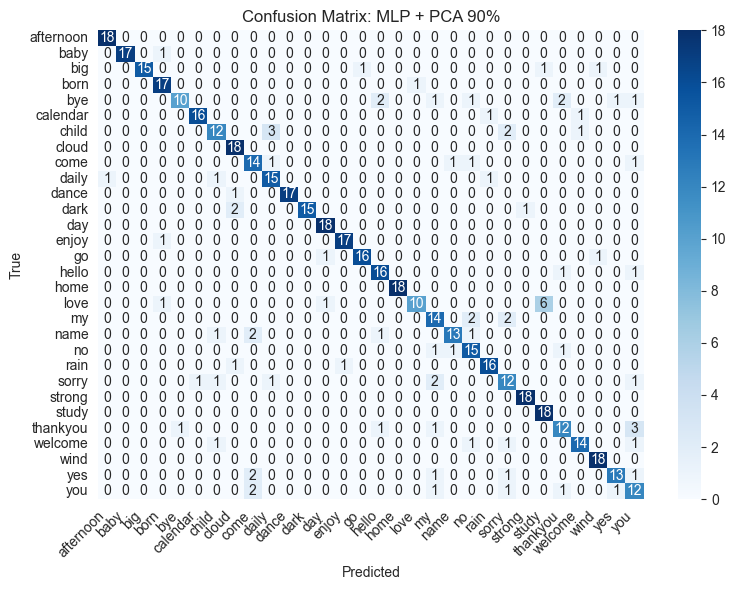


Applying PCA to keep 80% variance (fit on train)...
Original dim: 240 Reduced dim: 21
MLP + PCA 80% -> Acc: 0.7889, MacroF1: 0.7893
              precision    recall  f1-score   support

   afternoon       0.90      1.00      0.95        18
        baby       0.93      0.78      0.85        18
         big       1.00      0.89      0.94        18
        born       0.67      0.78      0.72        18
         bye       0.78      0.78      0.78        18
    calendar       0.74      0.78      0.76        18
       child       0.71      0.67      0.69        18
       cloud       0.74      0.78      0.76        18
        come       0.62      0.83      0.71        18
       daily       0.74      0.78      0.76        18
       dance       0.88      0.83      0.86        18
        dark       0.85      0.61      0.71        18
         day       0.81      0.94      0.87        18
       enjoy       0.89      0.89      0.89        18
          go       0.82      0.78      0.80        18
  

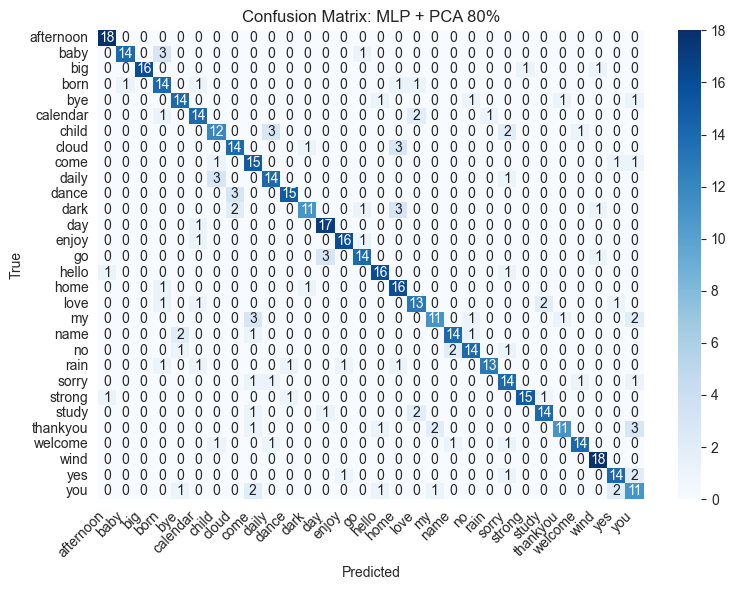


Saved summary to /Users/mayuri/Advanced data mining/Project 1/model_summary.csv
Saved PCA results to /Users/mayuri/Advanced data mining/Project 1/pca_results.csv

All done.


In [7]:
# ---- Main pipeline ----
def main():
    train_df, test_df, feature_cols, label_col = load_data()
    print(f"Using label column: {label_col}")
    print(f"Number of feature columns: {len(feature_cols)}")

    X_train, X_test, y_train, y_test, class_names = prepare_xy(train_df, test_df, feature_cols, label_col)

    # ---- Models to train ----
    models_to_run = [
        ("DecisionTree", DecisionTreeClassifier, {"random_state": RANDOM_STATE}),
        ("RandomForest", RandomForestClassifier, {"n_estimators": 200, "n_jobs": -1, "random_state": RANDOM_STATE}),
        ("kNN", KNeighborsClassifier, {"n_neighbors": 5}),
        ("MLP", MLPClassifier, {"hidden_layer_sizes": (128, 64), "max_iter": 300, "random_state": RANDOM_STATE}),
        ("SVM", SVC, {"kernel": "rbf", "probability": False, "random_state": RANDOM_STATE})
    ]

    results = []
    # Train and evaluate each
    for name, cls, params in models_to_run:
        inst = cls(**params)
        res = fit_and_eval(inst, X_train, y_train, X_test, y_test, class_names, name=name, save=True)
        results.append(res)

    # Summarize results
    summary = pd.DataFrame([{"name": r["name"], "accuracy": r["accuracy"], "f1_macro": r["f1_macro"]} for r in results])
    summary = summary.sort_values(by=["accuracy", "f1_macro"], ascending=False).reset_index(drop=True)
    print("\n===== Model Summary (sorted) =====")
    print(summary)

    # Pick top-2 by accuracy (tie-break on f1_macro)
    top2 = summary.head(2)
    print("\nTop 2 models chosen for PCA experiments:", top2["name"].tolist())
    top_models_info = [(r["name"], r["model"]) for r in results if r["name"] in top2["name"].tolist()]

    # Map name->class & params for retraining with PCA (we saved joblib but we want class & params)
    model_factory = {n: (cls, params) for n, cls, params in models_to_run}

    pca_variances = [0.90, 0.80]
    pca_results = {}
    for model_name, _ in top_models_info:
        cls, params = model_factory[model_name]
        pca_results[model_name] = []
        for v in pca_variances:
            res_pca = evaluate_with_pca(cls, params, X_train, y_train, X_test, y_test, class_names, variance_target=v, model_name_prefix=model_name)
            pca_results[model_name].append(res_pca)

    # Save summary to CSV
    out_summary = ROOT / "model_summary.csv"
    summary.to_csv(out_summary, index=False)
    print(f"\nSaved summary to {out_summary}")

    # Also save pca results
    pca_flat = []
    for k, arr in pca_results.items():
        for entry in arr:
            pca_flat.append({"model": k, **entry})
    pd.DataFrame(pca_flat).to_csv(ROOT / "pca_results.csv", index=False)
    print(f"Saved PCA results to {ROOT / 'pca_results.csv'}")

    print("\nAll done.")

if __name__ == "__main__":
    main()